In [1]:
# CSV Reader
# ==============================================================================
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

cases = pd.read_csv('covidcases.csv')

cases['date'] = pd.to_datetime(cases['date'], format='%Y/%m/%d')
cases = cases.set_index('date')
cases = cases.asfreq('SMS')
cases = cases.sort_index()
cases




,hospitalCases,newDailyNsoDeathsByDeathDate
date,,
2020-04-01,13637,924
2020-04-15,20582,1276
2020-05-01,14723,786
2020-05-15,10691,421
2020-06-01,7247,199
...,...,...
2022-08-01,12857,90
2022-08-15,10021,86
2022-09-01,6957,42


In [2]:
(cases.index == pd.date_range(start=cases.index.min(),
                             end=cases.index.max(),
                              freq=cases.index.freq)).all()



True

Train dates : 2020-04-01 00:00:00 --- 2022-04-01 00:00:00  (n=49)
Test dates  : 2022-04-15 00:00:00 --- 2022-10-01 00:00:00  (n=12)


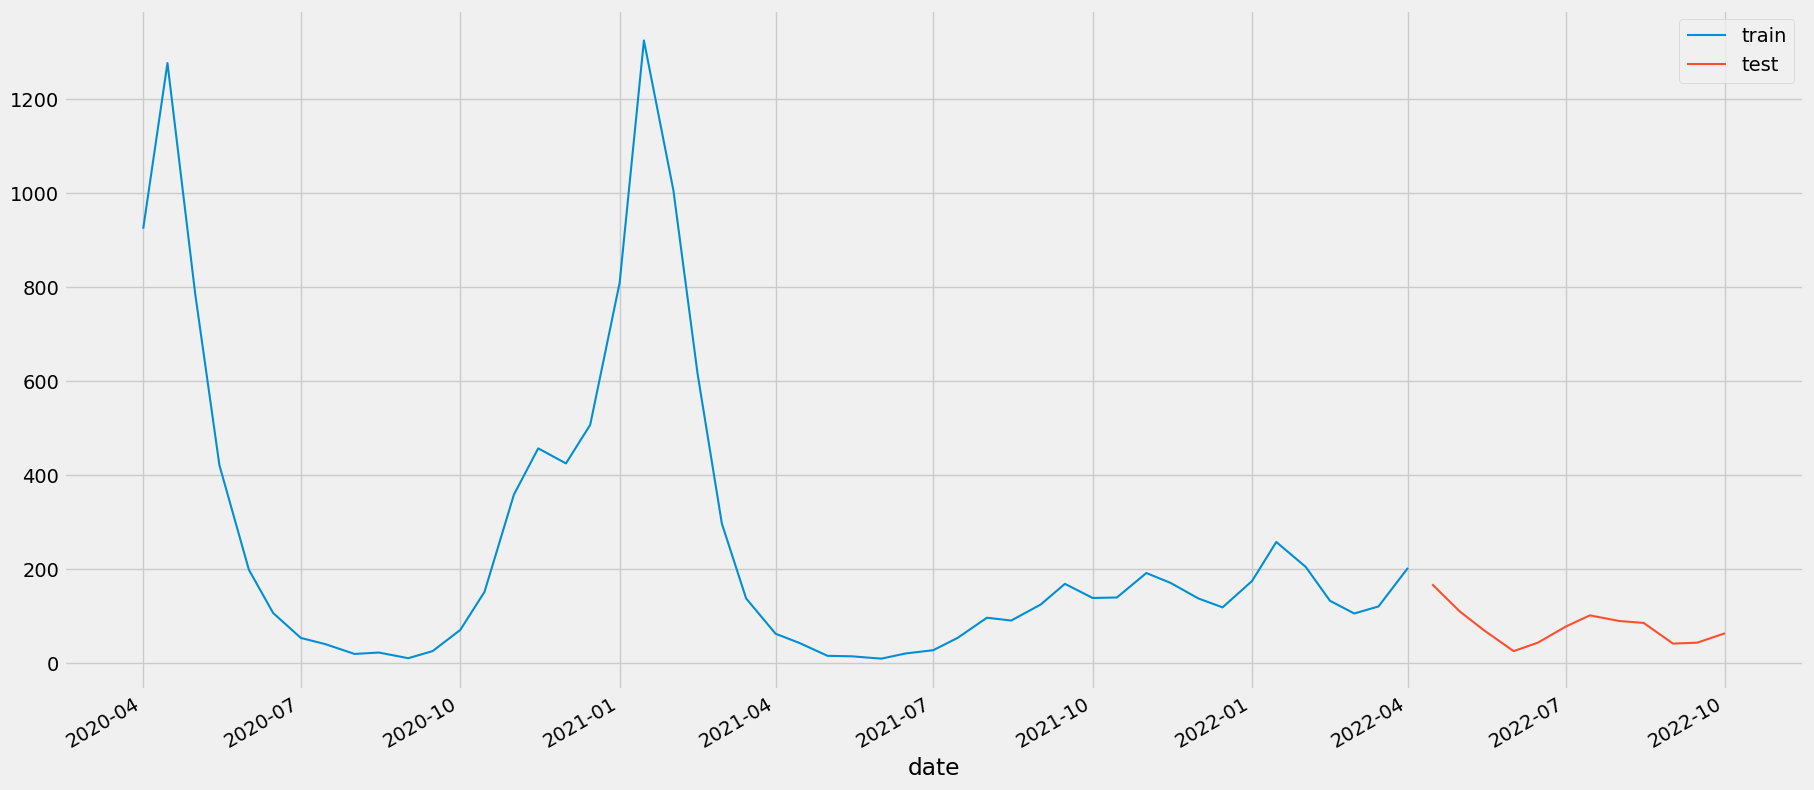

In [3]:
steps = 12
data_train = cases[:-steps]
data_test  = cases[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(20, 10))
data_train['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='train')
data_test['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='test')
ax.legend();

In [4]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6)

forecaster.fit(y=data_train['newDailyNsoDeathsByDeathDate'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-04-01 00:00:00'), Timestamp('2022-04-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: SMS-15 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-07 22:56:39 
Last fit date: 2022-11-07 22:56:39 
Skforecast version: 0.5.1 
Python version: 3.10.8 

In [5]:
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-04-15    213.15
2022-05-01    161.42
2022-05-15    132.50
2022-06-01    132.70
2022-06-15    186.89
Freq: SMS-15, Name: pred, dtype: float64

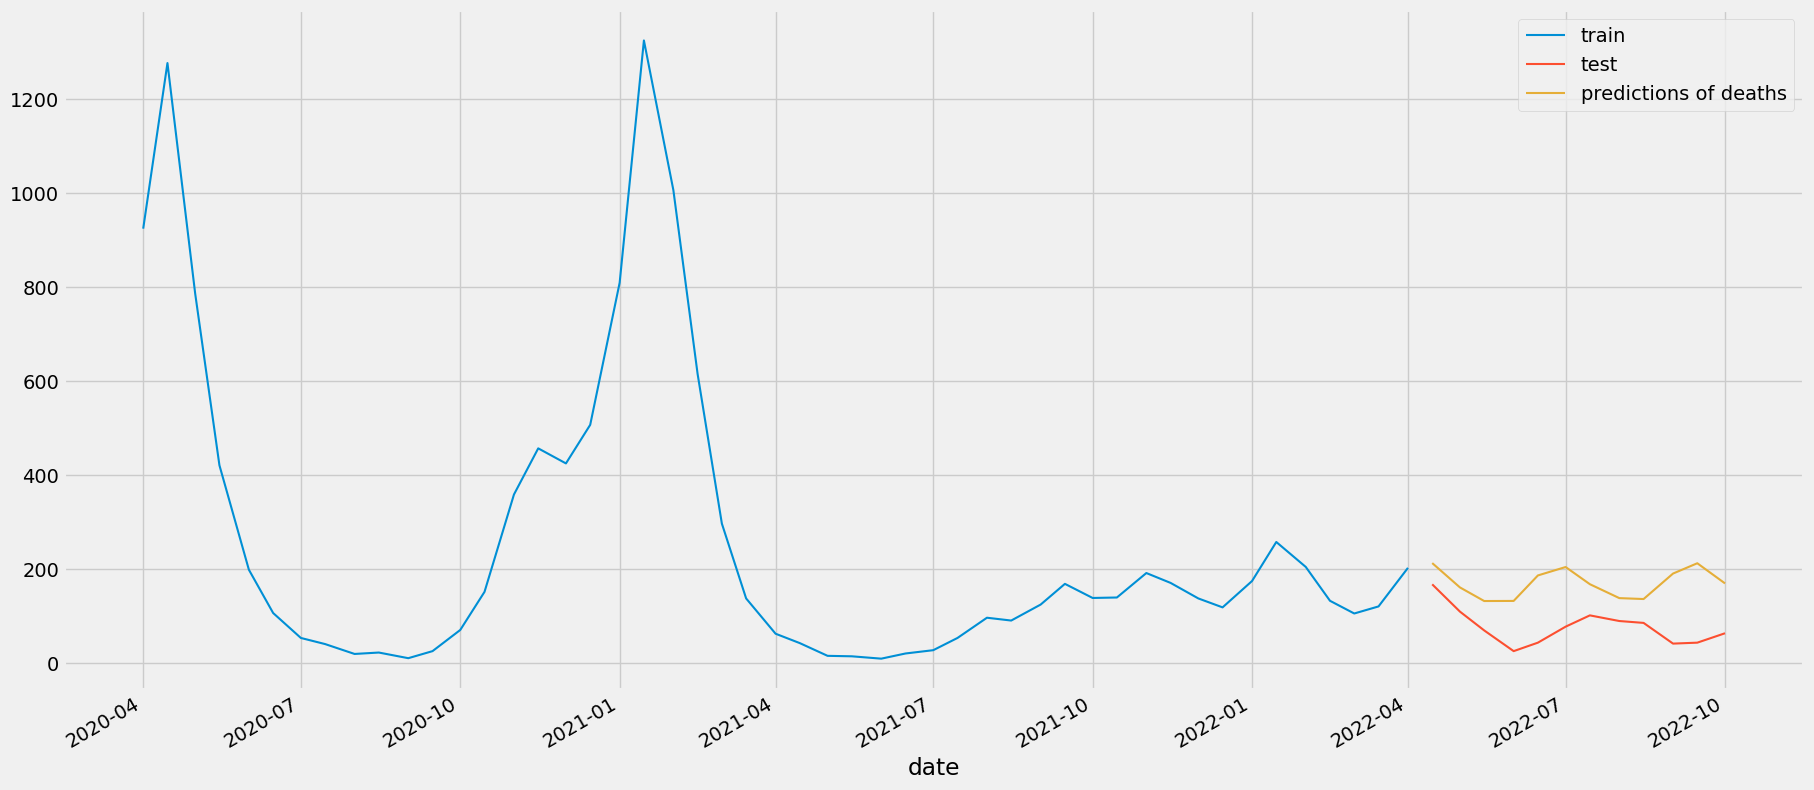

In [6]:
fig, ax=plt.subplots(figsize=(20, 10))
data_train['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='train')
data_test['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions of deaths')

ax.legend();

In [7]:
# Test error
# ==============================================================================
first_error_mse = mean_squared_error(
                y_true = data_test['newDailyNsoDeathsByDeathDate'],
                y_pred = predictions
            )

print("Test error (mse): {:.2f}".format(first_error_mse))

Test error (mse): 10640.01


In [14]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['newDailyNsoDeathsByDeathDate'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 113255.83945237537



In [15]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",113255.839452,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",113367.679081,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",113700.765416,10,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",113855.875457,3,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",113878.034040,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",113936.806400,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",119860.983778,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",120268.342081,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",120855.674147,10,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",121083.100337,3,100


In [16]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['newDailyNsoDeathsByDeathDate'])

In [17]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

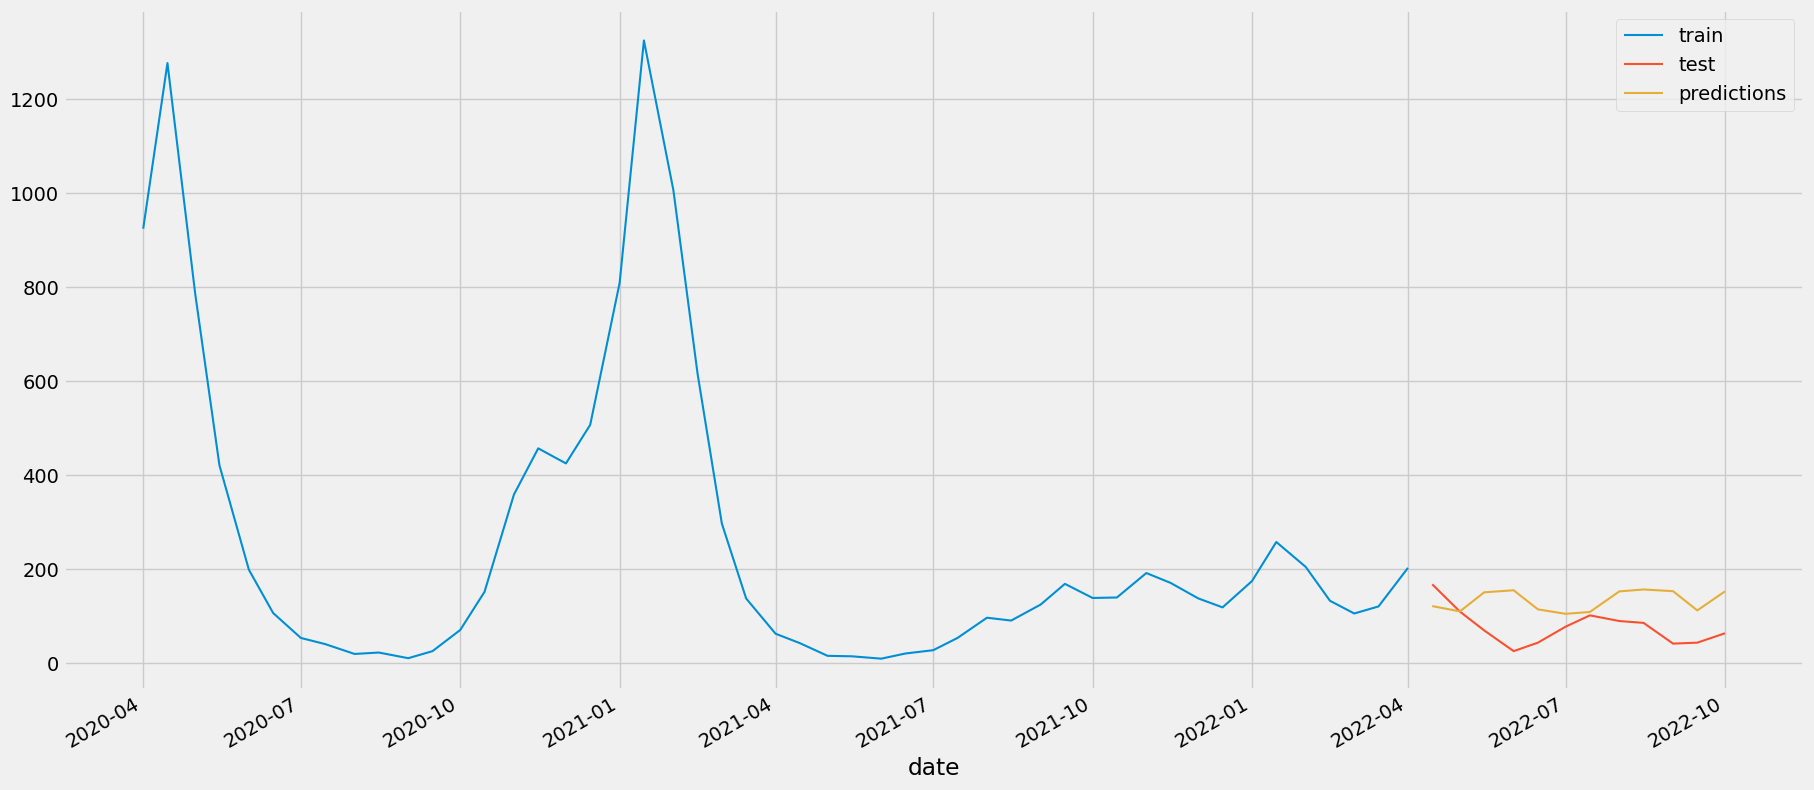

In [18]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 10))
data_train['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='train')
data_test['newDailyNsoDeathsByDeathDate'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [19]:
# Test error
# ==============================================================================
second_error_mse = mean_squared_error(
                y_true = data_test['newDailyNsoDeathsByDeathDate'],
                y_pred = predictions
            )

print("Test error (mse): {:.2f}".format(second_error_mse))

Test error (mse): 5444.67
